# Data Analysis of Water Audit Project

## 0. Import libraries and packages

In [1]:
import pandas as pd
import os
import shutil
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 1. Import the Data and Split it into Events

In [2]:
#The raw Data are organised according to the outlet type in outletData/flowData

names_of_outlets = ["kitchenBasin", "showerHead", "washingMachine", "washroomBasin"]

if os.path.isdir("outletData/eventData") == False:
    os.mkdir("outletData/eventData")

for outlet_name in names_of_outlets:
    outlet_file_path = "outletData/flowData"+'/'+outlet_name+".csv"
    event_dir = "outletData/eventData"+'/'+outlet_name+"_events"
    if os.path.isdir(event_dir) == True:
        shutil.rmtree(event_dir)
    os.mkdir(event_dir)
    
    df = pd.read_csv(outlet_file_path, sep=' ', header=None, names=['time', 'flow'])
    counter = 0
    startEvent = 0
    endEvent = 0
    outlet_ts = df.to_numpy()
    timegap = np.zeros([len(outlet_ts), 1])
    flow_val = outlet_ts[:,1]
    flow_threshold=2
    min_data_points=5
    timeLimit = 5
    curr_event_index = []
    
    for index in range(0, len(outlet_ts) - 1):
        timegap[index + 1] = outlet_ts[index + 1, 0] - outlet_ts[index, 0]
    
    for index in range(2, len(outlet_ts) - 1):
        if timegap[index] <= timeLimit and flow_val[index] > flow_threshold:
            curr_event_index.append(index - 1)
        else:
            if len(curr_event_index) >= min_data_points:
                startEvent = curr_event_index[0] if flow_val[curr_event_index[0]] > 0 else curr_event_index[1]
                endEvent = curr_event_index[-1] + 2
                counter+=1
                np.savetxt(event_dir + '/' + str(counter) + '.csv', outlet_ts[startEvent:endEvent], delimiter=' ' ,fmt="%d")    
            startEvent = 0
            endEvent = 0
            curr_event_index = []

## 2. Generate 2D Plots of longest Events of each Outlet

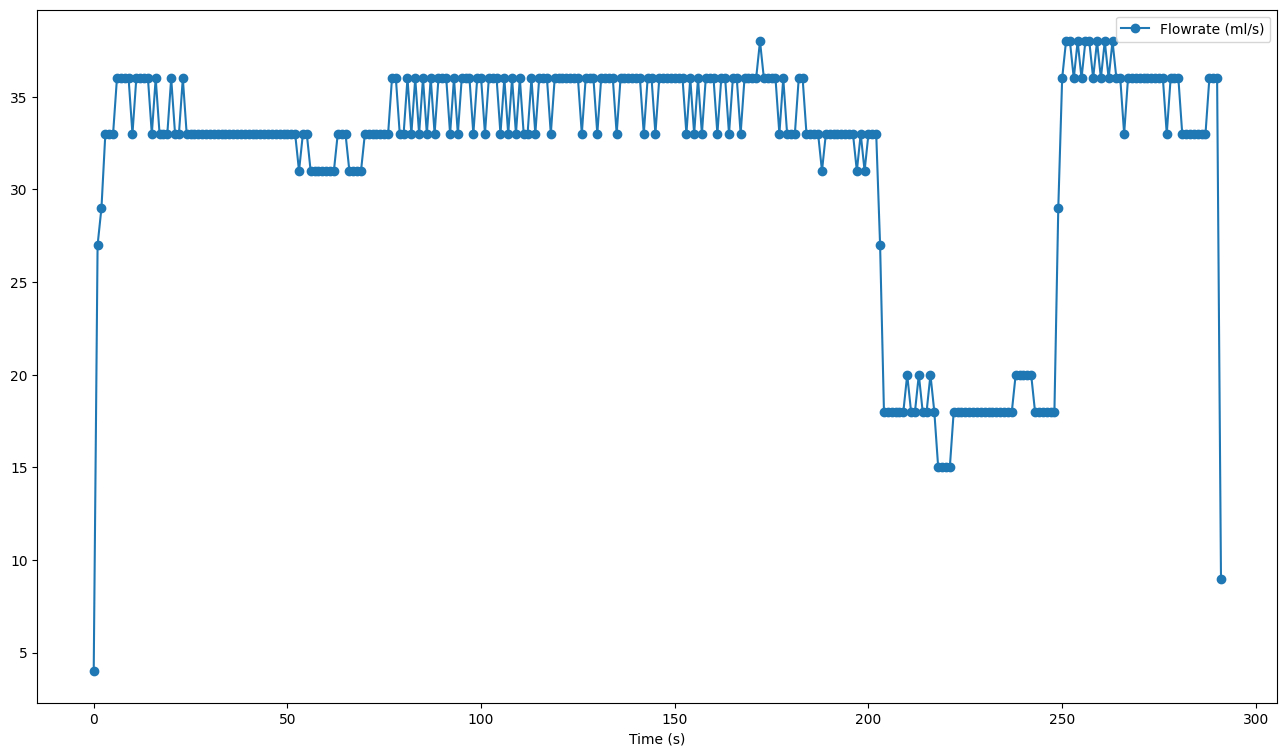

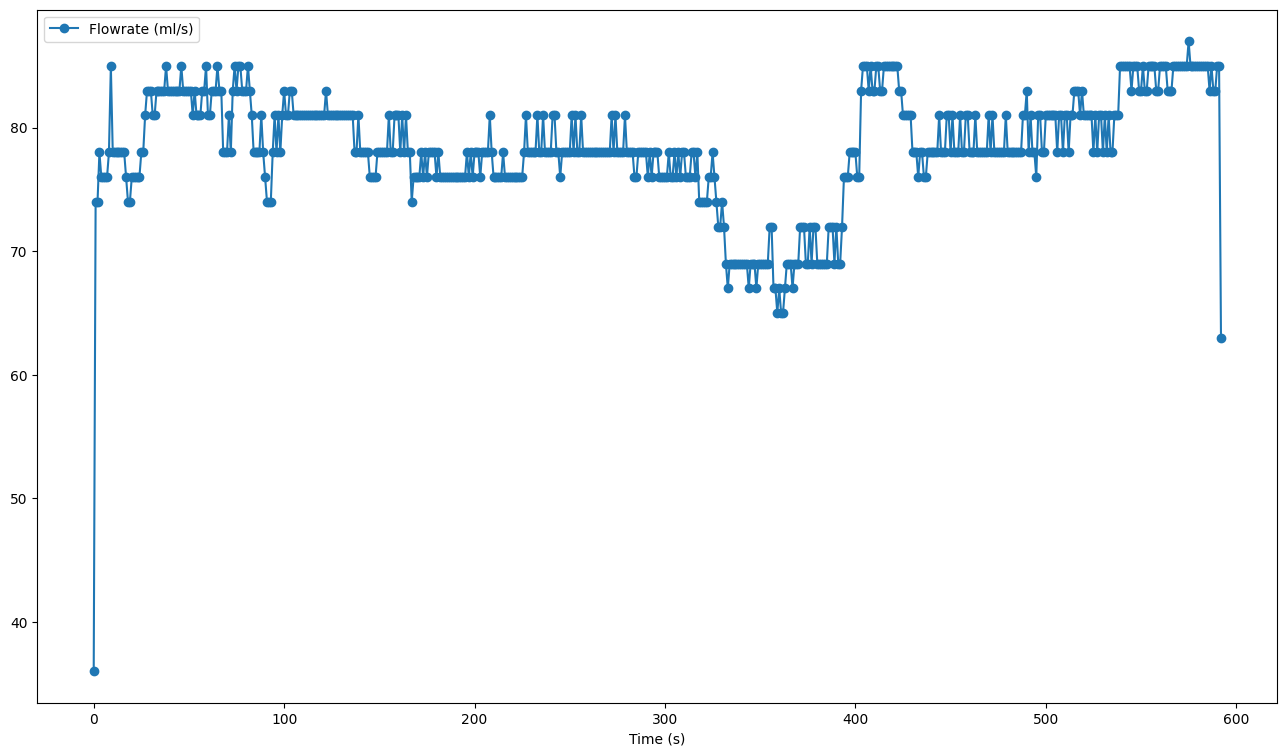

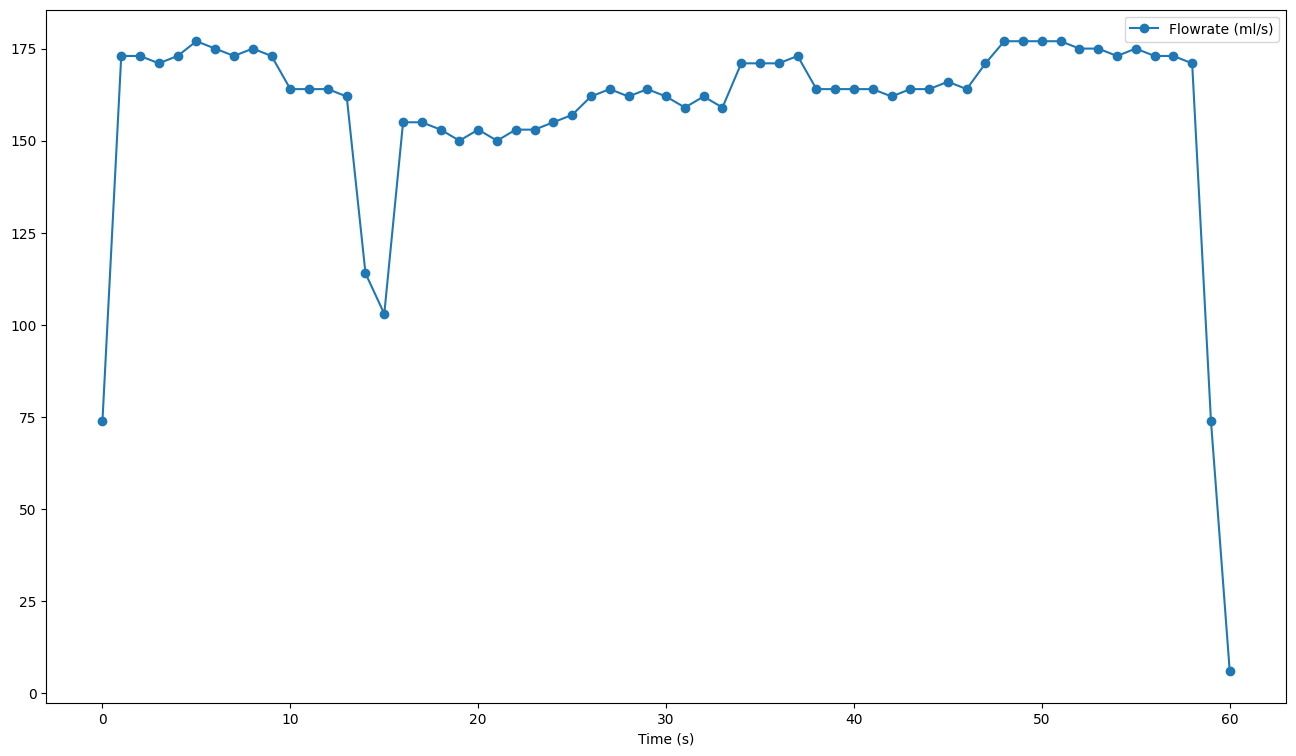

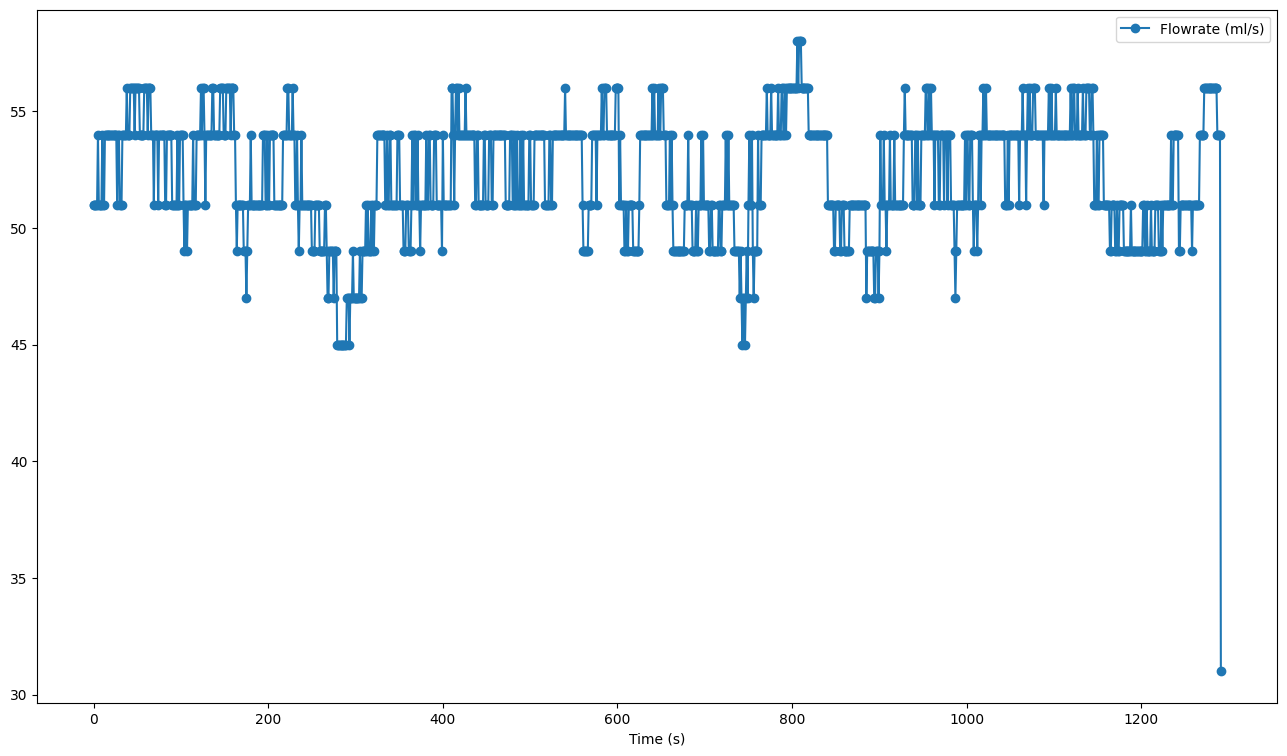

In [23]:
for outlet_events in os.scandir("outletData/eventData"):
    
    outlet_name = outlet_events.name.split('_',1)[0]
    maxActivity = 0
    prime_df = pd.DataFrame()

    for event in os.scandir(outlet_events):
        df = pd.read_csv(event.path, sep=' ', header=None, names=['Time (s)','Flowrate (ml/s)'])
        currActivity = len(df.index)
        if currActivity>maxActivity:
            maxActivity = currActivity
            prime_df = df
    
    ax = prime_df.plot(kind='line', use_index=True, y = 'Flowrate (ml/s)', figsize = (16, 9), style='-o')
    ax.set_xlabel("Time (s)")
    plt.show()
    fig = ax.get_figure()
    fig.savefig('plot_figures/'+outlet_name+'.png')

## 3. Extract Features from the Events

In [25]:
if os.path.isdir("outletData/featureData") == False:
    os.mkdir("outletData/featureData")

household_average_flow = []
household_volume = []
household_duration = []
household_outlet = []

for outlet_events in os.scandir("outletData/eventData"):
    
    outlet_name = outlet_events.name.split('_',1)[0]

    event_average_flow = []
    event_volume = []
    event_duration = []
    event_outlet = []
    for event in os.scandir(outlet_events):
        df = pd.read_csv(event.path, sep=' ', header=None)
        event_average_flow.append(df.loc[:,1].mean())
        event_volume.append(df.loc[:,1].sum())
        event_duration.append(df.iloc[-1,0] - df.iloc[0,0] + 1)
        event_outlet.append(outlet_name)
        
    data = {
    "AverageFlow": event_average_flow,
    "Volume": event_volume,
    "Duration": event_duration,
    "Outlet": event_outlet
    }
    df = pd.DataFrame(data)
    df.to_csv("outletData/featureData"+'/'+outlet_name+"_feature"+".csv", sep=' ', index=False)

    household_average_flow.extend(event_average_flow)
    household_volume.extend(event_volume)
    household_duration.extend(event_duration)
    household_outlet.extend(event_outlet)

data = {
    "AverageFlow": household_average_flow,
    "Volume": household_volume,
    "Duration": household_duration,
    "Outlet": household_outlet
    }

df = pd.DataFrame(data)
df.to_csv("outletData/featureData"+'/'+"all_outlets_feature"+".csv", sep=' ', index=False)
    

## 4. Generate 3D Plots of the Features of each Outlet

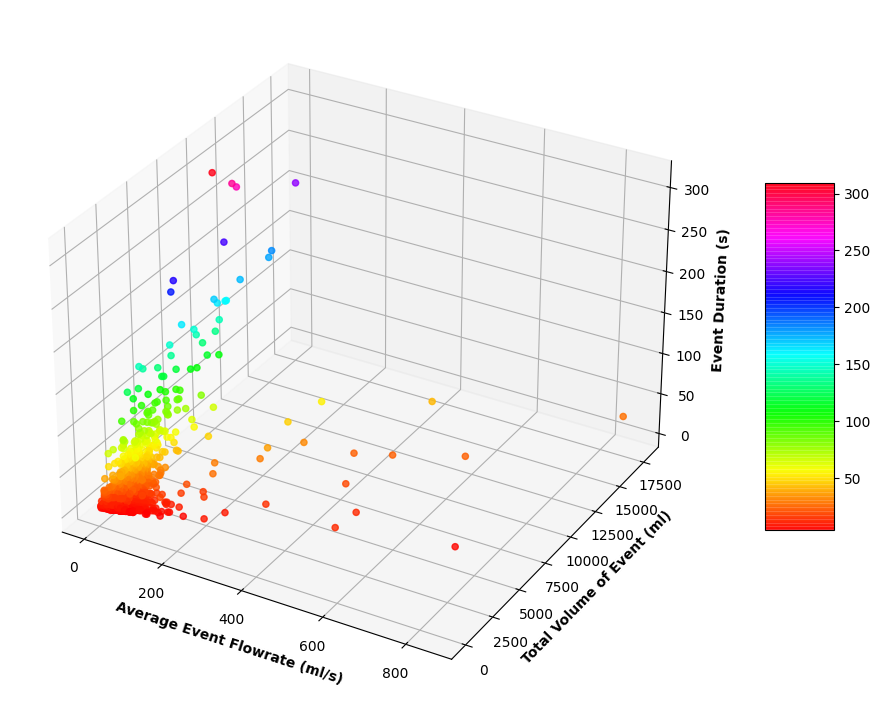

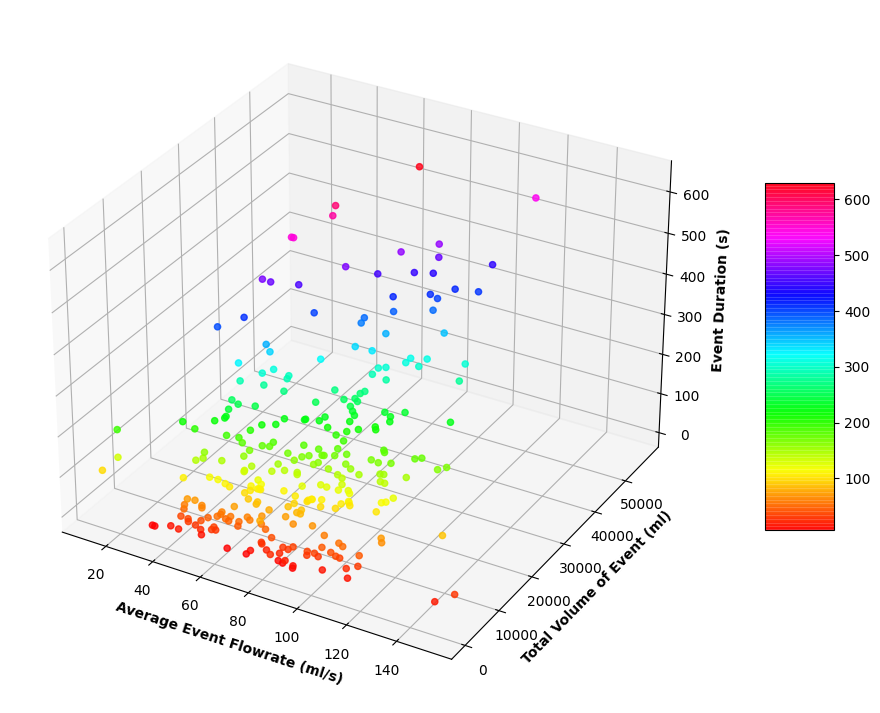

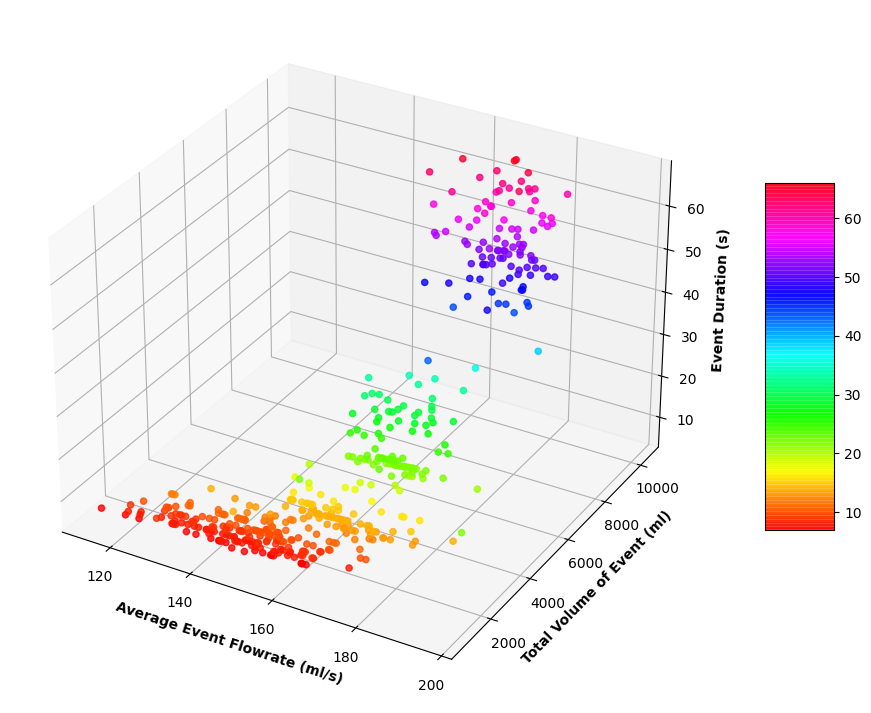

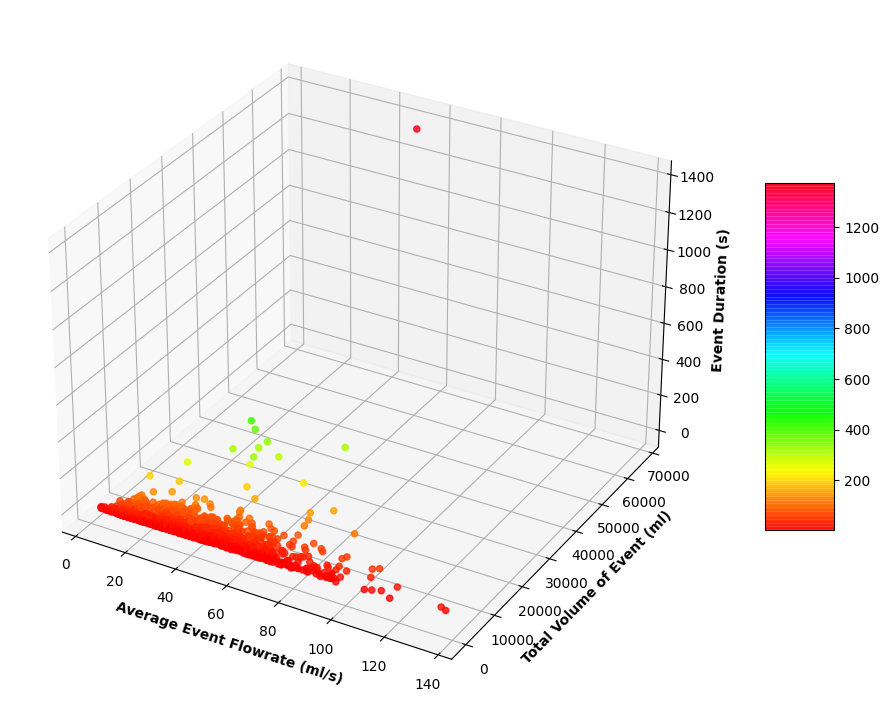

In [26]:
for outlet_name in names_of_outlets:
    fig = plt.figure(figsize = (16, 9))
    ax = plt.axes(projection ="3d")
    ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)
    my_cmap = plt.get_cmap('hsv')
    df = pd.read_csv("outletData/featureData/"+outlet_name+"_feature.csv", sep=' ')
    xdata = df.iloc[:,0]
    ydata = df.iloc[:,1]
    zdata = df.iloc[:,2]

    sctt = ax.scatter3D(xdata, ydata, zdata,
                        alpha = 0.8,
                        c = (zdata),
                        cmap = my_cmap)

    #plt.title(outlet_name+" 3D scatter plot")
    ax.set_xlabel('Average Event Flowrate (ml/s)', fontweight ='bold')
    ax.set_ylabel('Total Volume of Event (ml)', fontweight ='bold')
    ax.set_zlabel('Event Duration (s)', fontweight ='bold')
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
    plt.show()
    fig.savefig('plot_figures/'+outlet_name+'_feature_uncleaned.png')

## 5. Generate a 3D Plot with the Features of all the Outlets

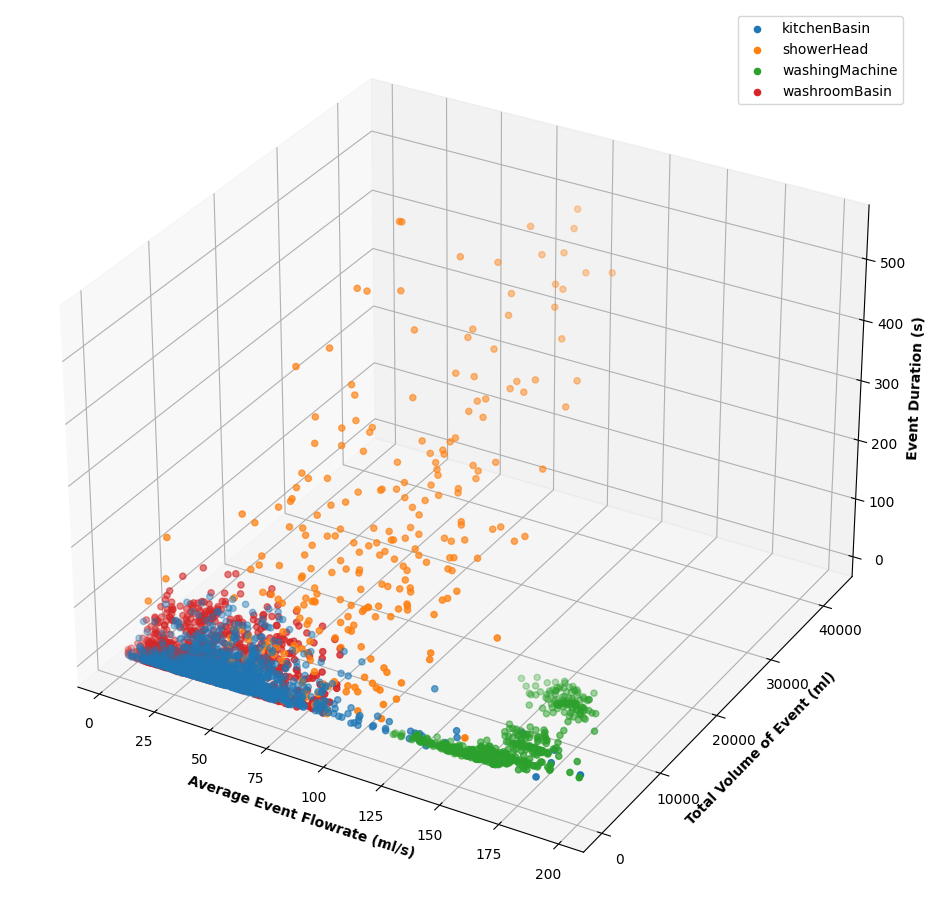

In [29]:
df = pd.read_csv("outletData/featureData/"+"all_outlets_feature"+".csv", sep=' ')
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

for grp_name, grp_idx in df.groupby('Outlet').groups.items():
    y = df.iloc[grp_idx,1]
    x = df.iloc[grp_idx,0]
    z = df.iloc[grp_idx,2]
    ax.scatter(x,y,z, label=grp_name)

ax.set_xlabel('Average Event Flowrate (ml/s)', fontweight ='bold')
ax.set_ylabel('Total Volume of Event (ml)', fontweight ='bold')
ax.set_zlabel('Event Duration (s)', fontweight ='bold')

ax.legend()
plt.show()
fig.savefig('plot_figures/all_outlets_feature_cleaned.png')

## 6. Clean the Data

In [28]:
from scipy import stats

household_feature_df = pd.DataFrame()
for outlet_name in names_of_outlets:
    df = pd.read_csv('outletData/featureData/'+outlet_name+'_feature.csv', sep=' ')
    df = df[(np.abs(stats.zscore(df.drop(columns=['Outlet']))) < 3).all(axis=1)]
    df.to_csv("outletData/featureData"+'/'+outlet_name+"_feature"+".csv", sep=' ', index=False)
    household_feature_df = household_feature_df.append(df, ignore_index = True)
household_feature_df.to_csv("outletData/featureData"+'/'+"all_outlets_feature"+".csv", sep=' ', index=False)
    

## 7. Split the Data into Training/Test Sets

In [17]:
df = pd.read_csv('outletData/featureData/all_outlets_feature.csv', sep=' ')
df = df.sample(frac=1).reset_index(drop=True)
X = df.drop(columns=["Outlet"])
y = df["Outlet"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 8. Create a Model

In [18]:
model = DecisionTreeClassifier()

## 9. Train the Model 

In [19]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

## 6. Make Predictions

In [20]:
predictions = model.predict(X_test)

## 7. Evaluate 

In [21]:
accuracy_score(y_test, predictions)

0.6757457846952011

In [31]:
print(classification_report(y_test, predictions))

                precision    recall  f1-score   support

  kitchenBasin       0.56      0.53      0.55       276
    showerHead       0.79      0.83      0.81        46
washingMachine       1.00      1.00      1.00       101
 washroomBasin       0.65      0.68      0.66       348

      accuracy                           0.68       771
     macro avg       0.75      0.76      0.75       771
  weighted avg       0.67      0.68      0.67       771



In [22]:
from sklearn import svm
from sklearn.metrics import classification_report

svm_model = svm.SVC(kernel='linear', gamma='auto', C=2)
svm_model.fit(X_train,y_train)
svm_predictions = svm_model.predict(X_test)
print(classification_report(y_test, svm_predictions))


                precision    recall  f1-score   support

  kitchenBasin       0.70      0.55      0.62       276
    showerHead       0.81      0.83      0.82        46
washingMachine       1.00      1.00      1.00       101
 washroomBasin       0.70      0.81      0.75       348

      accuracy                           0.74       771
     macro avg       0.80      0.80      0.80       771
  weighted avg       0.74      0.74      0.74       771



In [30]:
accuracy_score(y_test, svm_predictions)

0.7444876783398184